In [1]:
print("hello World")
!pip install mediapipe
!pip install opencv-python
!apt install ffmpeg


hello World
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp

2025-04-14 22:19:55.546183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744669195.759929      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744669195.828029      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Folder containing videos for the word "good"
VIDEO_FOLDER = '/kaggle/input/include/Adjectives_7of8/Adjectives/94. good'
STMAP_SAVE_FOLDER = '/kaggle/working/stmaps/good'
os.makedirs(STMAP_SAVE_FOLDER, exist_ok=True)

# Hollistic Landmarks Extraction 

In [4]:
# Initialize MediaPipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(static_image_mode=False)

def extract_stmap_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    landmarks_list = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        keypoints = []

        # Extract pose landmarks
        if results.pose_landmarks:
            for lm in results.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
        else:
            keypoints.extend([0]*99)  # 33 x 3

        # Extract left hand landmarks
        if results.left_hand_landmarks:
            for lm in results.left_hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
        else:
            keypoints.extend([0]*63)  # 21 x 3

        # Extract right hand landmarks
        if results.right_hand_landmarks:
            for lm in results.right_hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
        else:
            keypoints.extend([0]*63)

        # Extract face landmarks (optional, can skip for speed)
        if results.face_landmarks:
            for lm in results.face_landmarks.landmark[::10]:  # downsample from 468 to ~47
                keypoints.extend([lm.x, lm.y, lm.z])
        else:
            keypoints.extend([0]*141)  # 47 x 3

        landmarks_list.append(keypoints)

    cap.release()
    return np.array(landmarks_list)

# Code to Augment the videos 1. Speed Variation 2. Frame Interpolation
=

In [5]:
import os
import shutil

# Automation code to make augmentated videos for lesser video files and check them 
# based on cosine similarty
# List of input subdirectories (for your 6 selected words)
input_dirs = [
    "/kaggle/input/include/Adjectives_7of8/Adjectives/94. good",
    "/kaggle/input/include/Pronouns_1of2/Pronouns/41. you",
    "/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/85. Night",
    "/kaggle/input/include/Jobs_1of2/Jobs/91. Priest",
    "/kaggle/input/include/Adjectives_1of8/Adjectives/5. Beautiful",
    "/kaggle/input/include/Adjectives_2of8/Adjectives/14. thin"
]

# Output base directory
output_dir = "/kaggle/working/augmented_videos"
os.makedirs(output_dir, exist_ok=True)

for input_folder in input_dirs:
    label_name = os.path.basename(input_folder)
    print(f"\n Processing: {label_name}")

    # Count MP4 or MOV files
    original_files = [f for f in os.listdir(input_folder) if f.endswith((".MOV", ".MP4"))]
    original_count = len(original_files)
    print(f" Original videos: {original_count}")

    if original_count >= 20:
        print(f"Skipping {label_name} (already ≥ 20)")
        continue

    # Baseline count of all labels 
    needed_aug = 20 - original_count
    print(f" Augmenting to add {needed_aug} more")

    # Prepare output subfolder
    output_subfolder = os.path.join(output_dir, label_name)
    os.makedirs(output_subfolder, exist_ok=True)

    aug_count = 0
    aug_order = ['interp', 'slow', 'fast']  # Priority

    for file in original_files:
        if aug_count >= needed_aug:
            break

        input_path = os.path.join(input_folder, file)
        base_name = file.rsplit('.', 1)[0]  # remove .MOV/.MP4
        ext = os.path.splitext(file)[1]     # get the extension 
        
        for aug_type in aug_order:
            if aug_count >= needed_aug:
                break

            suffix = f"_{aug_type}{ext}"
            output_path = os.path.join(output_subfolder, base_name + suffix)

            if aug_type == 'interp':
                !ffmpeg -i "{input_path}" -vf "minterpolate='mi_mode=mci:mc_mode=aobmc:vsbmc=1:fps=60'" -c:v libx264 -crf 18 -preset slow "{output_path}" -y

            elif aug_type == 'slow':
                !ffmpeg -i "{input_path}" -filter:v "setpts=1.1*PTS" -c:v libx264 -crf 18 -preset slow "{output_path}" -y

            elif aug_type == 'fast':
                !ffmpeg -i "{input_path}" -filter:v "setpts=0.95*PTS" -c:v libx264 -crf 18 -preset slow "{output_path}" -y

            aug_count += 1
            print(f"Augmented ({aug_type}) → {output_path}")


 Processing: 94. good
 Original videos: 21
Skipping 94. good (already ≥ 20)

 Processing: 41. you
 Original videos: 21
Skipping 41. you (already ≥ 20)

 Processing: 85. Night
 Original videos: 15
 Augmenting to add 5 more


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744669207.308254      75 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744669207.382596      75 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744669207.389721      76 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744669207.390453      74 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744669207.393406      75 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744669207.412765     

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

# Checking the original files for any outliers

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# Your original video folders
input_dirs = [
    "/kaggle/input/include/Adjectives_7of8/Adjectives/94. good",
    "/kaggle/input/include/Pronouns_1of2/Pronouns/41. you",
    "/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/85. Night",
    "/kaggle/input/include/Jobs_1of2/Jobs/91. Priest",
    "/kaggle/input/include/Adjectives_1of8/Adjectives/5. Beautiful",
    "/kaggle/input/include/Adjectives_2of8/Adjectives/14. thin"
]

SIM_THRESHOLD = 0.85  # You can tweak this if needed
class_similarity_results = {}  # Optional: store similarity status per class

for folder_path in input_dirs:
    label_name = os.path.basename(folder_path)
    print(f"\n📂 Processing Class: {label_name}")

    video_files = [f for f in os.listdir(folder_path) if f.endswith((".MOV", ".MP4"))]
    if len(video_files) < 2:
        print("⚠️ Not enough videos to compare.")
        continue

    video_stmaps = {}

    print("🔍 Extracting STMaps...")
    for file in video_files:
        path = os.path.join(folder_path, file)
        try:
            stmap = extract_stmap_from_video(path)
            video_stmaps[file] = stmap
            print(f"✅ Extracted: {file} → shape {stmap.shape}")
        except:
            print(f"🚫 Failed to extract STMap for {file}")

    print("\n📊 Pairwise Cosine Similarity:")
    label_results = {}

    for file1 in video_files:
        sims = []
        stmap1 = video_stmaps.get(file1)
        if stmap1 is None:
            continue

        for file2 in video_files:
            if file1 == file2:
                continue

            stmap2 = video_stmaps.get(file2)
            if stmap2 is None:
                continue

            try:
                # Match frames between two videos
                min_frames = min(stmap1.shape[0], stmap2.shape[0])
                stmap1_fixed = stmap1[:min_frames]
                stmap2_fixed = stmap2[:min_frames]

                sim = cosine_similarity(
                    stmap1_fixed.flatten().reshape(1, -1),
                    stmap2_fixed.flatten().reshape(1, -1)
                )[0][0]
                sims.append(sim)

            except Exception as e:
                print(f"⚠️ Skipping {file1} ↔ {file2} due to error: {e}")

        if sims:
            avg_sim = np.mean(sims)
            status = "✅ Consistent" if avg_sim >= SIM_THRESHOLD else "❌ Outlier"
            print(f"{file1}: Avg Cosine Similarity = {avg_sim:.4f} → {status}")
            label_results[file1] = {
                "avg_similarity": avg_sim,
                "status": status
            }

    class_similarity_results[label_name] = label_results



📂 Processing Class: 94. good
🔍 Extracting STMaps...


W0000 00:00:1744670078.058716      74 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


✅ Extracted: MVI_9350.MOV → shape (45, 366)
✅ Extracted: MVI_9268.MOV → shape (46, 366)
✅ Extracted: MVI_5318.MOV → shape (44, 366)
✅ Extracted: MVI_5240.MOV → shape (65, 366)
✅ Extracted: MVI_5160.MOV → shape (62, 366)
✅ Extracted: MVI_9270.MOV → shape (46, 366)
✅ Extracted: MVI_9349.MOV → shape (41, 366)
✅ Extracted: MVI_5317.MOV → shape (49, 366)
✅ Extracted: MVI_5238.MOV → shape (49, 366)
✅ Extracted: MVI_9269.MOV → shape (48, 366)
✅ Extracted: MVI_9432.MOV → shape (59, 366)
✅ Extracted: MVI_9431.MOV → shape (59, 366)
✅ Extracted: MVI_9511.MOV → shape (56, 366)
✅ Extracted: MVI_9510.MOV → shape (62, 366)
✅ Extracted: MVI_9351.MOV → shape (50, 366)
✅ Extracted: MVI_9512.MOV → shape (50, 366)
✅ Extracted: MVI_5158.MOV → shape (73, 366)
✅ Extracted: MVI_5316.MOV → shape (46, 366)
✅ Extracted: MVI_5159.MOV → shape (63, 366)
✅ Extracted: MVI_5239.MOV → shape (56, 366)
✅ Extracted: MVI_9430.MOV → shape (67, 366)

📊 Pairwise Cosine Similarity:
MVI_9350.MOV: Avg Cosine Similarity = 0.9627 

# As files where saved wiht "..MOV" saving to wokring directory with .MOV


In [7]:
import os
import shutil

labels_to_copy = [
    "85. Night",
    "91. Priest",
    "5. Beautiful",
    "14. thin"
]

for label_name in labels_to_copy:
    src_folder = f"/kaggle/input/data-augmentation/augmented_videos/{label_name}"
    dst_folder = f"/kaggle/working/augmented_videos/{label_name}"

    os.makedirs(dst_folder, exist_ok=True)

    for file in os.listdir(src_folder):
        src_path = os.path.join(src_folder, file)
        # optional filename fix
        new_name = file.replace("..MOV", ".MOV") if "..MOV" in file else file
        dst_path = os.path.join(dst_folder, new_name)

        shutil.copy2(src_path, dst_path)
        print(f"✅ Copied: {dst_path}")


✅ Copied: /kaggle/working/augmented_videos/85. Night/MVI_5523_interp.MOV
✅ Copied: /kaggle/working/augmented_videos/85. Night/MVI_5523_fast.MOV
✅ Copied: /kaggle/working/augmented_videos/85. Night/MVI_5523_slow.MOV
✅ Copied: /kaggle/working/augmented_videos/85. Night/MVI_4664_slow.MOV
✅ Copied: /kaggle/working/augmented_videos/85. Night/MVI_4664_interp.MOV
✅ Copied: /kaggle/working/augmented_videos/91. Priest/MVI_5342_slow.MOV
✅ Copied: /kaggle/working/augmented_videos/91. Priest/MVI_4770_fast.MOV
✅ Copied: /kaggle/working/augmented_videos/91. Priest/MVI_4770_interp.MOV
✅ Copied: /kaggle/working/augmented_videos/91. Priest/MVI_5342_interp.MOV
✅ Copied: /kaggle/working/augmented_videos/91. Priest/MVI_4770_slow.MOV
✅ Copied: /kaggle/working/augmented_videos/5. Beautiful/MVI_9570_fast.MOV
✅ Copied: /kaggle/working/augmented_videos/5. Beautiful/MVI_9724_interp.MOV
✅ Copied: /kaggle/working/augmented_videos/5. Beautiful/MVI_9569_slow.MOV
✅ Copied: /kaggle/working/augmented_videos/5. Beautif

# and saving their reference landmarkss
## which file wile be saved for cosine


In [8]:
import os

input_dirs = [
    "/kaggle/input/include/Adjectives_7of8/Adjectives/94. good",
    "/kaggle/input/include/Pronouns_1of2/Pronouns/41. you",
    "/kaggle/input/include/Days_and_Time_3of3/Days_and_Time/85. Night",
    "/kaggle/input/include/Jobs_1of2/Jobs/91. Priest",
    "/kaggle/input/include/Adjectives_1of8/Adjectives/5. Beautiful",
    "/kaggle/input/include/Adjectives_2of8/Adjectives/14. thin"
]

augmented_root = "/kaggle/working/augmented_videos"
to_filter_cosine = []  #  this will hold the labels that have augmented files

for input_folder in input_dirs:
    label = os.path.basename(input_folder)
    aug_folder = os.path.join(augmented_root, label)

    if os.path.exists(aug_folder) and os.path.isdir(aug_folder):
        files = [f for f in os.listdir(aug_folder) if f.endswith((".MOV", ".MP4"))]
        if files:
            to_filter_cosine.append((label, input_folder))  # save both label & source
            print(f"✅ {label} will be checked for cosine filtering (found {len(files)} videos)")
        else:
            print(f"⚠️ Folder exists but no video files in {label}")
    else:
        print(f"❌ No augmented folder found for {label}")

reference_landmarks = {} # To store the original videos landmarks 

for label, original_folder in to_filter_cosine:
    print(f"\n Extracting original STMap for label: {label}")

    # Look for one original .MOV or .MP4 file
    files = [f for f in os.listdir(original_folder) if f.endswith((".MOV", ".MP4"))]
    if not files:
        print(f" No original videos found in {original_folder}")
        continue

    selected_file = files[0]  # pick the first one
    file_path = os.path.join(original_folder, selected_file)

    try:
        stmap = extract_stmap_from_video(file_path)
        if label not in reference_landmarks:
            reference_landmarks[label] = {}
        reference_landmarks[label][selected_file] = stmap
        print(f"✅ Extracted STMap for {selected_file} | shape = {stmap.shape}")
    except Exception as e:
        print(f"❌ Failed for {selected_file}: {e}")

❌ No augmented folder found for 94. good
❌ No augmented folder found for 41. you
✅ 85. Night will be checked for cosine filtering (found 5 videos)
✅ 91. Priest will be checked for cosine filtering (found 5 videos)
✅ 5. Beautiful will be checked for cosine filtering (found 12 videos)
✅ 14. thin will be checked for cosine filtering (found 12 videos)

 Extracting original STMap for label: 85. Night
✅ Extracted STMap for MVI_5523.MOV | shape = (43, 366)

 Extracting original STMap for label: 91. Priest
✅ Extracted STMap for MVI_4770.MOV | shape = (61, 366)

 Extracting original STMap for label: 5. Beautiful
✅ Extracted STMap for MVI_9570.MOV | shape = (79, 366)

 Extracting original STMap for label: 14. thin
✅ Extracted STMap for MVI_9612.MOV | shape = (71, 366)


# Check the cosine Similarty

In [9]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Match frame length
def match_frame_length(ref, target):
    if ref.shape[0] == target.shape[0]:
        return target
    elif target.shape[0] > ref.shape[0]:
        return target[:ref.shape[0]]
    else:
        pad = np.zeros((ref.shape[0] - target.shape[0], target.shape[1]))
        return np.vstack((target, pad))

# Step 2: Compute and save cosine similarity averages
cosine_scores = {}  # Final result dict

for label, files_dict in reference_landmarks.items():
    print(f"\n📂 Processing Label: {label}")
    
    aug_folder = os.path.join("/kaggle/working/augmented_videos", label)
    if not os.path.exists(aug_folder):
        print(f"❌ No augmented folder for {label}")
        continue

    # Use the first available reference STMap
    original_file, ref_landmarks = list(files_dict.items())[0]
    print(f"🔗 Using {original_file} as reference")

    # Collect cosine similarities for all augmentations in this class
    all_sims = []
    for aug_file in os.listdir(aug_folder):
        if not aug_file.endswith((".MOV", ".MP4")):
            continue
        aug_path = os.path.join(aug_folder, aug_file)
        try:
            aug_landmarks = extract_stmap_from_video(aug_path)
            aug_landmarks = match_frame_length(ref_landmarks, aug_landmarks)

            sim = cosine_similarity(
                ref_landmarks.flatten().reshape(1, -1),
                aug_landmarks.flatten().reshape(1, -1)
            )[0][0]
            all_sims.append(sim)
        except Exception as e:
            print(f"⚠️ Failed: {aug_file} → {e}")

    # Save average similarity for this label
    if all_sims:
        cosine_scores[label] = np.mean(all_sims)
        print(f"📊 Avg Cosine Similarity for {label}: {cosine_scores[label]:.4f}")
    else:
        cosine_scores[label] = 0.0  # fallback



📂 Processing Label: 85. Night
🔗 Using MVI_5523.MOV as reference
📊 Avg Cosine Similarity for 85. Night: 0.9685

📂 Processing Label: 91. Priest
🔗 Using MVI_4770.MOV as reference
📊 Avg Cosine Similarity for 91. Priest: 0.9627

📂 Processing Label: 5. Beautiful
🔗 Using MVI_9570.MOV as reference
📊 Avg Cosine Similarity for 5. Beautiful: 0.9429

📂 Processing Label: 14. thin
🔗 Using MVI_9612.MOV as reference
📊 Avg Cosine Similarity for 14. thin: 0.9503


# visualizng the cosine similarty


{'85. Night': 0.9685119195355986, '91. Priest': 0.9627272052052851, '5. Beautiful': 0.9429348786723217, '14. thin': 0.950253589026841}


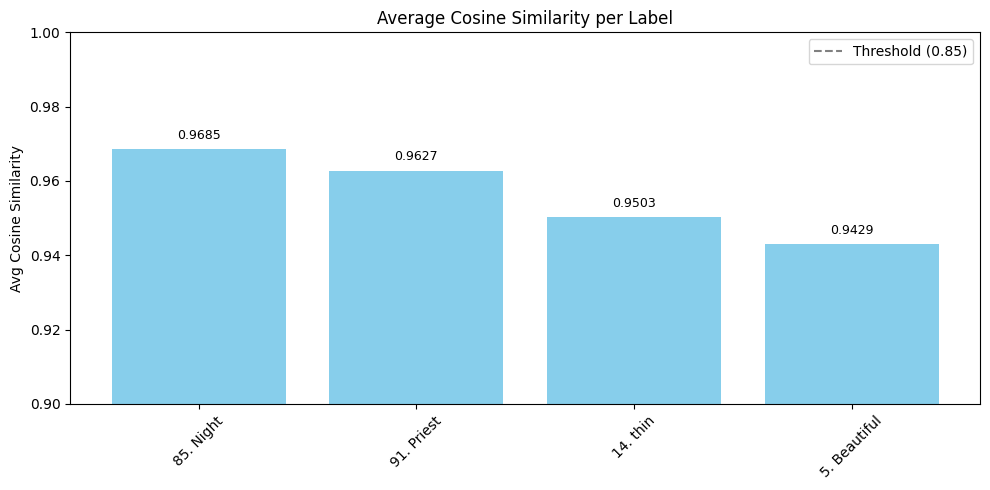

In [10]:
import matplotlib.pyplot as plt

# Example cosine_scores dictionary
print(cosine_scores)

# Sort by similarity for cleaner visualization
labels = list(cosine_scores.keys())
scores = list(cosine_scores.values())
sorted_pairs = sorted(zip(labels, scores), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_scores = zip(*sorted_pairs)

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(sorted_labels, sorted_scores, color="skyblue")
plt.axhline(0.85, color='gray', linestyle='--', label='Threshold (0.85)')
plt.title("Average Cosine Similarity per Label")
plt.ylabel("Avg Cosine Similarity")
plt.xticks(rotation=45)
plt.ylim(0.9, 1.0)
plt.legend()

# Add value labels
for bar, score in zip(bars, sorted_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f"{score:.4f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [11]:
import os
import shutil

# Base directories
original_base = "/kaggle/input/include"
output_base = "/kaggle/working/combined_videos"
os.makedirs(output_base, exist_ok=True)

# Original video locations
original_map = {
    "94. good": "Adjectives_7of8/Adjectives/94. good",
    "41. you": "Pronouns_1of2/Pronouns/41. you",
    "85. Night": "Days_and_Time_3of3/Days_and_Time/85. Night",
    "91. Priest": "Jobs_1of2/Jobs/91. Priest",
    "5. Beautiful": "Adjectives_1of8/Adjectives/5. Beautiful",
    "14. thin": "Adjectives_2of8/Adjectives/14. thin"
}

# Augmented folders that exist
augmented_folders = {
    "14. thin": "/kaggle/working/augmented_videos/14. thin",
    "5. Beautiful": "/kaggle/working/augmented_videos/5. Beautiful",
    "85. Night": "/kaggle/working/augmented_videos/85. Night",
    "91. Priest": "/kaggle/working/augmented_videos/91. Priest"
}

# Process each class
for label, original_rel_path in original_map.items():
    print(f"\n📂 Merging videos for: {label}")

    original_folder = os.path.join(original_base, original_rel_path)
    output_folder = os.path.join(output_base, label)
    os.makedirs(output_folder, exist_ok=True)

    # Copy original videos
    if os.path.exists(original_folder):
        for file in os.listdir(original_folder):
            if file.endswith((".MOV", ".MP4")):
                shutil.copy2(os.path.join(original_folder, file), os.path.join(output_folder, file))

    # Copy augmented videos (if they exist for this label)
    if label in augmented_folders:
        aug_folder = augmented_folders[label]
        for file in os.listdir(aug_folder):
            if file.endswith((".MOV", ".MP4")):
                shutil.copy2(os.path.join(aug_folder, file), os.path.join(output_folder, file))

    print(f"✅ Combined total: {len(os.listdir(output_folder))} files")



📂 Merging videos for: 94. good
✅ Combined total: 21 files

📂 Merging videos for: 41. you
✅ Combined total: 21 files

📂 Merging videos for: 85. Night
✅ Combined total: 20 files

📂 Merging videos for: 91. Priest
✅ Combined total: 20 files

📂 Merging videos for: 5. Beautiful
✅ Combined total: 20 files

📂 Merging videos for: 14. thin
✅ Combined total: 16 files


In [12]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

In [13]:
import os
import cv2
import numpy as np
import mediapipe as mp

mp_holistic = mp.solutions.holistic

def extract_holistic_landmarks(frame, holistic):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(rgb_frame)

    # Fixed-size vector: 42 hand + 468 face + 33 pose = 543 points × 3 coordinates = 1629 features
    landmark_vector = np.zeros(1629, dtype=np.float32)

    # Hands (42 points: 21 left + 21 right)
    if results.left_hand_landmarks:
        left_hand = np.array([(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark]).flatten()
        landmark_vector[:63] = left_hand  # 21 × 3 = 63
    if results.right_hand_landmarks:
        right_hand = np.array([(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark]).flatten()
        landmark_vector[63:126] = right_hand  # Next 63

    # Face (468 points)
    if results.face_landmarks:
        face = np.array([(lm.x, lm.y, lm.z) for lm in results.face_landmarks.landmark]).flatten()
        landmark_vector[126:126 + 468*3] = face  # 468 × 3 = 1404

    # Pose (33 points)
    if results.pose_landmarks:
        pose = np.array([(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]).flatten()
        landmark_vector[126 + 468*3:] = pose  # 33 × 3 = 99

    return landmark_vector

def process_videos(root_folder):
    holistic = mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5)

    dataset = []  # List of sequences (one per video)
    labels = []   # One label per video

    sign_folders = sorted(os.listdir(root_folder))
    print(f"📁 Detected categories: {sign_folders}")

    for sign_folder in sign_folders:
        sign_path = os.path.join(root_folder, sign_folder)
        if not os.path.isdir(sign_path):
            continue

        print(f"\n🔄 Processing label: {sign_folder}")
        video_files = [f for f in os.listdir(sign_path) if f.lower().endswith(('.mov', '.mp4', '.avi', '.mkv', '.wmv', '.flv', '.webm'))]
        print(f"🎞️ Total videos: {len(video_files)}")

        for video_file in video_files:
            video_path = os.path.join(sign_path, video_file)
            print(f"🎬 {video_file}")

            cap = cv2.VideoCapture(video_path)
            video_landmarks = []  # Landmarks for this video

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                landmark_vector = extract_holistic_landmarks(frame, holistic)
                video_landmarks.append(landmark_vector)

            cap.release()
            if video_landmarks:  # Only add if some frames were processed
                dataset.append(np.array(video_landmarks))  # Shape: (num_frames, 1629)
                labels.append(sign_folder)

    # Save as pickle since sequences have variable lengths
    import pickle
    with open("holistic_landmarks_videos.pkl", "wb") as f:
        pickle.dump(dataset, f)
    with open("holistic_labels_videos.pkl", "wb") as f:
        pickle.dump(labels, f)

    print("\n✅ Dataset saved successfully!")
    holistic.close()

# Example usage
# process_videos("path/to/root_folder")

In [14]:
# Run for your specific folder
root_folder = "/kaggle/working/combined_videos/"
process_videos(root_folder)

📁 Detected categories: ['14. thin', '41. you', '5. Beautiful', '85. Night', '91. Priest', '94. good']

🔄 Processing label: 14. thin
🎞️ Total videos: 16
🎬 MVI_9612.MOV


W0000 00:00:1744670432.798837    1386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744670432.856289    1386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744670432.859006    1387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744670432.859410    1388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744670432.863998    1386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744670432.877587    1388 inference_feedback_manager.cc:114] Feedback manager 

🎬 MVI_9609.MOV
🎬 MVI_9612_slow.MOV
🎬 MVI_9610_interp.MOV
🎬 MVI_9611_interp.MOV
🎬 MVI_9609_slow.MOV
🎬 MVI_9612_interp.MOV
🎬 MVI_9611_slow.MOV
🎬 MVI_9609_interp.MOV
🎬 MVI_9609_fast.MOV
🎬 MVI_9611_fast.MOV
🎬 MVI_9612_fast.MOV
🎬 MVI_9611.MOV
🎬 MVI_9610_slow.MOV
🎬 MVI_9610.MOV
🎬 MVI_9610_fast.MOV

🔄 Processing label: 41. you
🎞️ Total videos: 21
🎬 MVI_9998.MOV
🎬 MVI_9924.MOV
🎬 MVI_9923.MOV
🎬 MVI_0069.MOV
🎬 MVI_9885.MOV
🎬 MVI_9888.MOV
🎬 MVI_9925.MOV
🎬 MVI_9996.MOV
🎬 MVI_9961.MOV
🎬 MVI_0068.MOV
🎬 MVI_0016.MOV
🎬 MVI_9887.MOV
🎬 MVI_0017.MOV
🎬 MVI_0015.MOV
🎬 MVI_9997.MOV
🎬 MVI_9962.MOV
🎬 MVI_0067.MOV
🎬 MVI_9926.MOV
🎬 MVI_9886.MOV
🎬 MVI_9999.MOV
🎬 MVI_9960.MOV

🔄 Processing label: 5. Beautiful
🎞️ Total videos: 20
🎬 MVI_9571.MOV
🎬 MVI_9723.MOV
🎬 MVI_9723_slow.MOV
🎬 MVI_9724_slow.MOV
🎬 MVI_9570_fast.MOV
🎬 MVI_9723_interp.MOV
🎬 MVI_9724.MOV
🎬 MVI_9572.MOV
🎬 MVI_9570.MOV
🎬 MVI_9569_fast.MOV
🎬 MVI_9569_slow.MOV
🎬 MVI_9570_slow.MOV
🎬 MVI_9724_interp.MOV
🎬 MVI_9724_fast.MOV
🎬 MVI_9726.MOV
🎬 MVI_9569.MOV


In [15]:
import pickle

# Correct file paths
landmarks_file = '/kaggle/working/holistic_landmarks_videos.pkl'
labels_file = '/kaggle/working/holistic_labels_videos.pkl'

# Loading the pickle files
with open(landmarks_file, 'rb') as f:
    x = pickle.load(f)  # List of NumPy arrays (one per video)

with open(labels_file, 'rb') as f:
    y = pickle.load(f)  # List of labels (one per video)

# Print shapes and lengths
print(f'Number of videos landmarks sequences: {len(x)}')
for i, landmark_seq in enumerate(x[:5]):  # Print first 5 for inspection
    print(f'Landmark sequence {i} shape: {landmark_seq.shape}')
print(f'Number of labels: {len(y)}')
print(f'Sample labels: {y[:5]}')  # Print first 5 labels

Number of videos landmarks sequences: 118
Landmark sequence 0 shape: (71, 1629)
Landmark sequence 1 shape: (62, 1629)
Landmark sequence 2 shape: (78, 1629)
Landmark sequence 3 shape: (152, 1629)
Landmark sequence 4 shape: (152, 1629)
Number of labels: 118
Sample labels: ['14. thin', '14. thin', '14. thin', '14. thin', '14. thin']


## 118 videos processed
## (T, D)  T: No of frame    ; D: No of Dimension 
42 hand landmarks (21 per hand × 2) × 3 (x, y, z) = 126
468 face landmarks × 3 = 1404
33 pose landmarks × 3 = 99
Total = 126 + 1404 + 99 = 1629

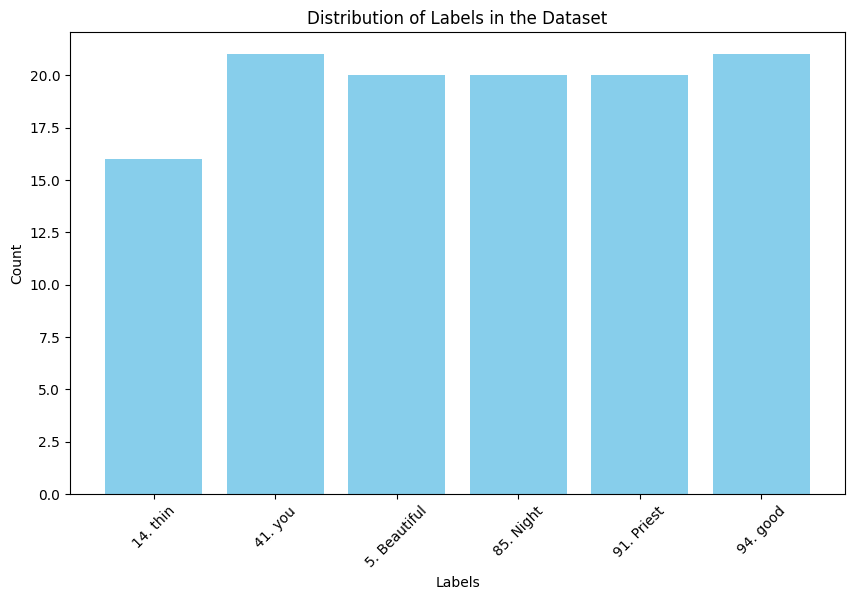

Label Distribution:
Label: 14. thin, Count: 16
Label: 41. you, Count: 21
Label: 5. Beautiful, Count: 20
Label: 85. Night, Count: 20
Label: 91. Priest, Count: 20
Label: 94. good, Count: 21


In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(y)

# Get the unique labels and their counts
labels, counts = zip(*label_counts.items())

# Plotting the label distribution
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in the Dataset')
plt.xticks(rotation=45)
plt.show()


# Alternatively, you can print the counts
print("Label Distribution:")
for label, count in label_counts.items():
    print(f'Label: {label}, Count: {count}')

## Visuallzing the frames

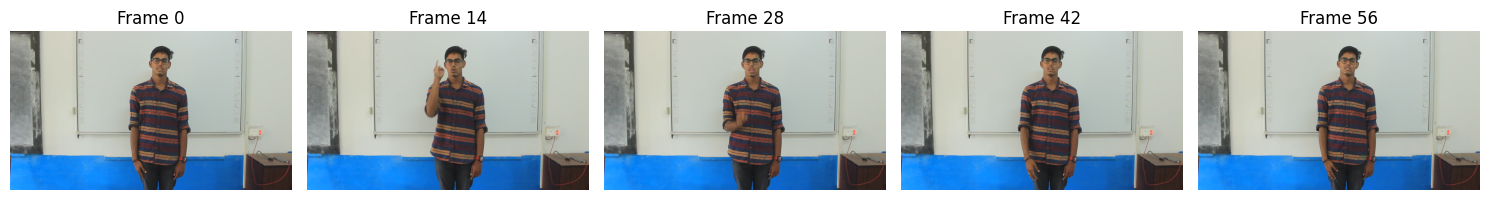

In [17]:
import cv2
import os
import matplotlib.pyplot as plt

def show_video_frames(video_path, num_frames=5):
    """
    Display `num_frames` evenly spaced frames from the given video.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Pick evenly spaced frame indices
    frame_indices = [int(i * total_frames / num_frames) for i in range(num_frames)]

    frames = []
    for idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if idx in frame_indices:
            # Convert BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
    cap.release()

    # Plot the frames
    plt.figure(figsize=(15, 5))
    for i, frame in enumerate(frames):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f"Frame {frame_indices[i]}")
    plt.tight_layout()
    plt.show()

# 🔍 Example usage
video_path = "/kaggle/input/include/Adjectives_2of8/Adjectives/14. thin/MVI_9612.MOV"
show_video_frames(video_path, num_frames=5)


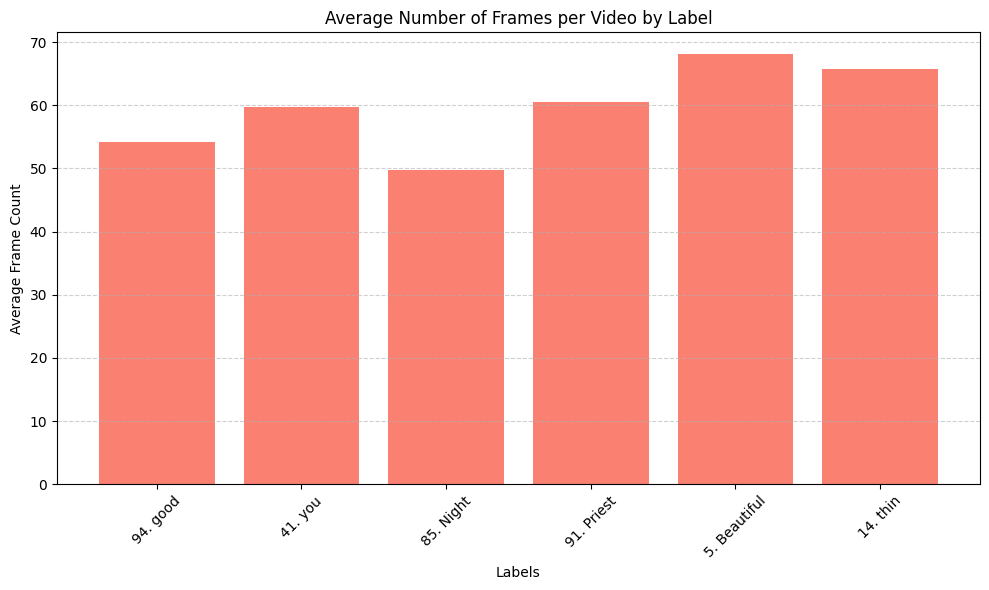

In [18]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Update your root path
root_folder = "/kaggle/input/include"

# Mapping label names to their folder paths
label_paths = {
    "94. good": "Adjectives_7of8/Adjectives/94. good",
    "41. you": "Pronouns_1of2/Pronouns/41. you",
    "85. Night": "Days_and_Time_3of3/Days_and_Time/85. Night",
    "91. Priest": "Jobs_1of2/Jobs/91. Priest",
    "5. Beautiful": "Adjectives_1of8/Adjectives/5. Beautiful",
    "14. thin": "Adjectives_2of8/Adjectives/14. thin"
}

# Dictionary to hold total frames per label
frame_data = defaultdict(list)

for label, path in label_paths.items():
    full_path = os.path.join(root_folder, path)
    for video in os.listdir(full_path):
        if video.endswith((".MOV", ".MP4")):
            cap = cv2.VideoCapture(os.path.join(full_path, video))
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_data[label].append(frame_count)
            cap.release()

# Calculate average frame count
avg_frames = {label: np.mean(frames) for label, frames in frame_data.items()}

# Plot average frame counts
plt.figure(figsize=(10, 6))
plt.bar(avg_frames.keys(), avg_frames.values(), color='salmon')
plt.xlabel("Labels")
plt.ylabel("Average Frame Count")
plt.title("Average Number of Frames per Video by Label")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
